In [24]:
import fipy as fp  ## finite volume PDE solver
from fipy.tools import numerix  ## requirement for FiPy, in practice same as numpy
import copy  ## we need the deepcopy() function because some FiPy objects are mutable
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py
import datetime

plt.rcParams.update({'font.size': 18})

def delta_func(x, epsilon, coeff):
    return ((x < epsilon) & (x > -epsilon)) * \
        (coeff * (1 + numerix.cos(numerix.pi * x / epsilon)) / (2 * epsilon))

def plot_solution(solution_array,ticks=None,levels=300,logdiff=10,figsize=(10,4),duration=0.001,nt=1000):
    if ticks == None:
        ticks = logdiff
    else:
        ticks = ticks
    
    dt = duration / nt
    sol_min = solution_array[:,:,1].min()
    sol_max = solution_array[:,:,1].max()
    logmax = math.ceil(np.log10(sol_max))
    logmin = logmax - logdiff
    numofticks = ticks
    div = logdiff // numofticks
    power = np.arange((logmax - (numofticks * div)), logmax, div)
    array1 = np.zeros(len(power)) + 10.
    ticks1 = np.power(array1, power)
    levels1 = np.logspace(logmin,logmax,levels, base=10.0)
    norm = matplotlib.colors.LogNorm(vmin=(10 ** logmin),vmax=sol_max)
    formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
    fig = plt.figure(figsize=figsize)
    plot = plt.contourf(solution_array[0,:,0], np.linspace(dt,duration,nt), solution_array[:,:,1],
                        levels=levels1, norm=norm, cmap=plt.cm.jet)
    axes = plt.gca()
    axes.set_facecolor((0.,0.,0.25)) ## dark blue will display where the values are too small
    axes.set_yscale('log')
    cbar = plt.colorbar(ticks=ticks1, format=formatter)
    cbar.set_label(r'Density (a. u.)')
    plt.xlabel('normalized radius')
    plt.ylabel(r'log$_{10}$[time (s)]')
    plt.title(r'Density of runaway electrons')
    return

def coeff_plot(conv_i, diff_i):
    fig_conv = plt.figure(figsize=(8.5,3))
    plt.plot(*conv_i.T)
    plt.title('Convection coefficient')
    fig_diff = plt.figure(figsize=(8.5,3))
    plt.plot(*diff_i.T)
    plt.title('Diffusion coefficient')
    
def hdf5_save(fname, solution, diff, conv, duration):
    now = datetime.datetime.now()
    date_time = now.strftime("%Y%m%d_%H.%M.%S")
    f_Out = h5py.File(fname + "_" + date_time + ".hdf5", "w")
    h5solution = f_Out.create_dataset("01_solution", data=solution)
    h5duration = f_Out.create_dataset("02_duration", data=duration)
    h5conv = f_Out.create_dataset("03_convcoeff", data=conv)
    h5diff = f_Out.create_dataset("04_diffcoeff", data=diff)    
    
def plot_hdf5(fname, plotcoeff=False, logdiff=5):
    f_In = h5py.File(fname, "r")
    h5solution = f_In["01_solution"]
    h5duration = f_In["02_duration"]
    nt = h5solution.shape[0]
    plot_solution(h5solution[()], logdiff=logdiff, duration=h5duration[()], nt=nt)
    if plotcoeff == True:
        h5conv = f_In["03_convcoeff"]
        h5diff = f_In["04_diffcoeff"]
        coeff_plot(conv_i=h5conv[()], diff_i=h5diff[()])
    else:
        1

def solve_DiracIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
                  diracLoc = 0.85, diracCoeff = 1., diracPercentage = 2,
                  conv_file = 'convC.txt', diff_file = 'diffC.txt',  plotcoeff = False,
                  levels = 300, logdiff = 10, ticks = None, figsize=(10,4), hdf5 = False):
    
    dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
    dt = duration / nt  ## length of one timestep
    solution = np.zeros((nt,nr,2))
    for j in range(nr):
        solution[:,j,0] = (j * dr) + (dr / 2) + R_from

    mesh = fp.CylindricalGrid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
    mesh = mesh + (R_from,)  ## translation of the mesh to R_from
    n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep
    diracWidth = int((nr / 100) * diracPercentage)
    n.setValue(delta_func(mesh.x - diracLoc, diracWidth * dr, diracCoeff))
    conv_data = np.genfromtxt(conv_file, delimiter=',')
    diff_data = np.genfromtxt(diff_file, delimiter=',')
    conv_i = np.zeros((nr, 2))
    diff_i = np.zeros((nr, 2))
    for i in range(conv_i.shape[0]):
        conv_i[i, 0] = R_from + (i * dr) + (dr / 2)

    for i in range(diff_i.shape[0]):
        diff_i[i, 0] = R_from + (i * dr) + (dr / 2)

    conv_i[:,1] = np.interp(conv_i[:,0],conv_data[:,0],conv_data[:,1])
    diff_i[:,1] = np.interp(diff_i[:,0],diff_data[:,0],diff_data[:,1])
    dC = diff_i[:,1]
    diffCoeff = fp.CellVariable(mesh=mesh, value=dC)
    cC = conv_i[:,1]
    convCoeff = fp.CellVariable(mesh=mesh, value=[cC])
    gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
    valueRight = 0.  ## density value (at the "right end of the radius")
    n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
    n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
    convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge
    diffCoeff.setValue(0.001, where=mesh.x<(R_from + dr))  ## diffusion coefficient almost 0 at inner edge
    eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
          - fp.ConvectionTerm(coeff=convCoeff))
    for i in range(nt):
        eq.solve(var=n, dt=dt)
        solution[i,0:nr,1]=copy.deepcopy(n.value)

    plot_solution(solution,ticks=ticks,levels=levels,logdiff=logdiff,figsize=figsize,
                  duration=duration, nt=nt)
    if plotcoeff == True:
        coeff_plot(conv_i=conv_i, diff_i=diff_i)
    else:
        1
    
    if hdf5 == True:
        hdf5_save(fname="DiracIC",solution=solution, conv=conv_i, diff=diff_i, duration=duration)
    else:
        1
    
    return solution

def solve_uniformIC(R_from = 0.7, R_to = 1.0, nr = 1000, duration = 0.001, nt = 1000,
                    conv_file = 'convC.txt', diff_file = 'diffC.txt', plotcoeff = False,
                    levels = 300, logdiff = 10, ticks = None, figsize=(10,4), hdf5 = False):
    
    dr = (R_to - R_from) / nr  ## distance between the centers of the mesh cells
    dt = duration / nt  ## length of one timestep
    solution = np.zeros((nt,nr,2))
    for j in range(nr):
        solution[:,j,0] = (j * dr) + (dr / 2) + R_from

    mesh = fp.CylindricalGrid1D(dx=dr, nx=nr)  ## 1D mesh based on the radial coordinates 
    mesh = mesh + (R_from,)  ## translation of the mesh to R_from
    n = fp.CellVariable(mesh=mesh)  ## fipy.CellVariable for the density solution in each timestep
    conv_data = np.genfromtxt(conv_file, delimiter=',')
    diff_data = np.genfromtxt(diff_file, delimiter=',')
    conv_i = np.zeros((nr, 2))
    diff_i = np.zeros((nr, 2))
    for i in range(conv_i.shape[0]):
        conv_i[i, 0] = R_from + (i * dr) + (dr / 2)

    for i in range(diff_i.shape[0]):
        diff_i[i, 0] = R_from + (i * dr) + (dr / 2)

    conv_i[:,1] = np.interp(conv_i[:,0],conv_data[:,0],conv_data[:,1])
    diff_i[:,1] = np.interp(diff_i[:,0],diff_data[:,0],diff_data[:,1])
    dC = diff_i[:,1]
    diffCoeff = fp.CellVariable(mesh=mesh, value=dC)
    cC = conv_i[:,1]
    convCoeff = fp.CellVariable(mesh=mesh, value=[cC])
    n.setValue(1.0)
    gradLeft = (0.,)  ## density gradient (at the "left side of the radius") - must be a vector
    valueRight = 0.  ## density value (at the "right end of the radius")
    n.faceGrad.constrain(gradLeft, where=mesh.facesLeft)  ## applying Neumann boundary condition
    n.constrain(valueRight, mesh.facesRight)  ## applying Dirichlet boundary condition
    convCoeff.setValue(0, where=mesh.x<(R_from + dr))  ## convection coefficient 0 at the inner edge
    diffCoeff.setValue(0.001, where=mesh.x<(R_from + dr))  ## diffusion coefficient almost 0 at inner edge
    eq = (fp.TransientTerm() == fp.DiffusionTerm(coeff=diffCoeff)
          - fp.ConvectionTerm(coeff=convCoeff))
    for i in range(nt):
        eq.solve(var=n, dt=dt)
        solution[i,0:nr,1]=copy.deepcopy(n.value)

    plot_solution(solution,ticks=ticks,levels=levels,logdiff=logdiff,figsize=figsize,
                  duration=duration, nt=nt)
    if plotcoeff == True:
        coeff_plot(conv_i=conv_i, diff_i=diff_i)
    else:
        1
    
    if hdf5 == True:
        hdf5_save(fname="uniformIC", solution=solution, conv=conv_i, diff=diff_i, duration=duration)
    else:
        1
    
    return solution

### Functions and their arguments

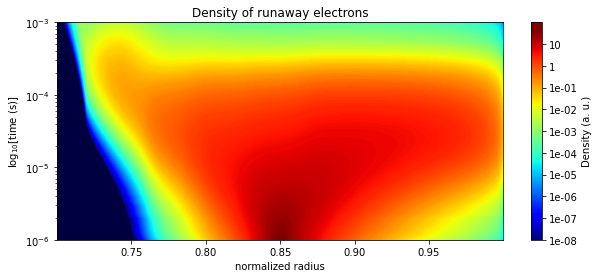

In [28]:
sol_Dirac = solve_DiracIC()

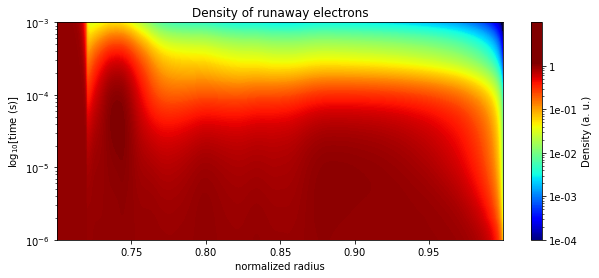

In [29]:
sol_uniform = solve_uniformIC(logdiff=5)

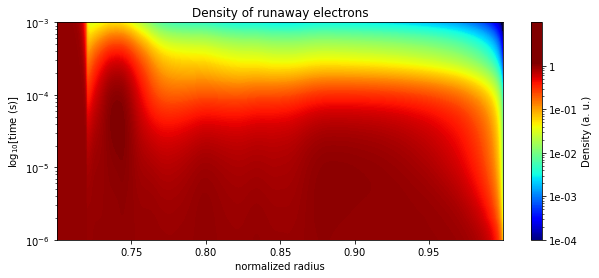

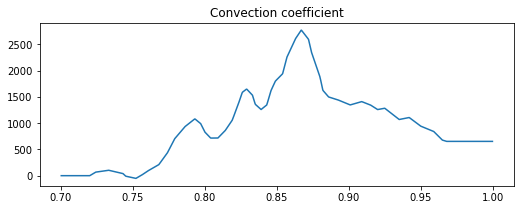

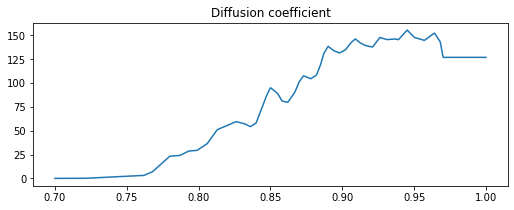

In [25]:
plot_hdf5("uniformIC.hdf5", plotcoeff=True, logdiff=5)

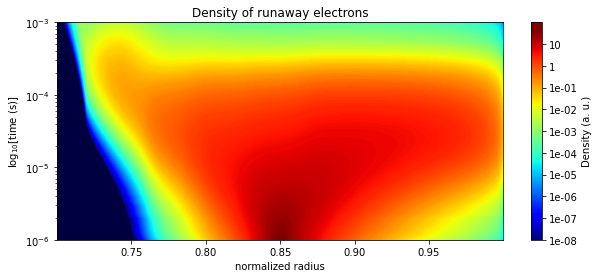

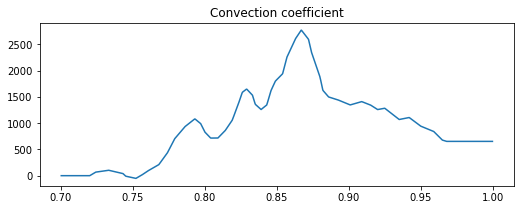

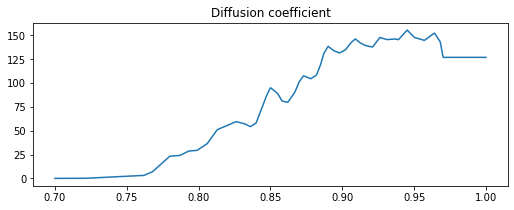

In [27]:
plot_hdf5("DiracIC.hdf5", plotcoeff=True, logdiff=10)